### Josh Barrios 09/18/2020

Notebook for testing image transformation functions

Define transformations

In [3]:
import numpy as np
from torchvision import transforms
from PIL import Image
import torch

class RotateAndScale:
    def __init__(self, angle, new_height, new_width):
        self.angle = angle
        self.new_height = new_height
        self.new_width = new_width

    def __call__(self, x):
        angle = self.angle
        x = transforms.functional.rotate(x, angle, expand=True)
        y = transforms.functional.resize(x, [self.new_height, self.new_width])
        return y


def transform_input(im, pts, angle, new_height, new_width):
    h = im.shape[1]
    w = im.shape[2]
    num_pts = np.int(pts.shape[0] / 2)

    # # Choose random rotation angle and scaling for this batch
    # angle = random.choice(range(360))
    # scale = random.choice(np.linspace(0.5, 2, 4))
    # [new_height, new_width] = [np.int(np.round(h * scale)), np.int(np.round(w * scale))]
    warp_input = RotateAndScale(angle, new_height, new_width)

    transform_im = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Lambda(warp_input),
        transforms.ToTensor()
    ])
    # for the point image, we don't need to convert to PIL
    transform_ptim = transforms.Compose([
        transforms.Lambda(warp_input),
    ])

    # Get transformed point locations by creating an image of each point and performing the same transformation on it
    new_pts = np.zeros([16], dtype=int)
    for k in range(num_pts):
        pt_im = np.zeros([h, w], dtype='bool')
        pt_loc = [np.int(np.round(pts[k] * h)), np.int(np.round(pts[k + 8] * w))]
        # Single points often disappear when transformed, so we make a 4x4 point
        pt_im[np.int(pt_loc[0]) - 6:np.int(pt_loc[0]) + 6, np.int(pt_loc[1]) - 6:np.int(pt_loc[1]) + 6] = 1
        pt_im = Image.fromarray(pt_im)
        pt_im = transform_ptim(pt_im)
        pt_im = np.array(pt_im)
        pt = np.where(pt_im == 1)
        pt_inds = [np.int(np.round(np.mean(pt[0]))), np.int(np.round(np.mean(pt[1])))]
        new_pts[k] = pt_inds[0]
        new_pts[k + 8] = pt_inds[1]
    new_pts = torch.DoubleTensor(new_pts).unsqueeze(dim=0)

    new_im = transform_im(im).unsqueeze(dim=0)
    return new_im, new_pts


Import images, run through transformations to get new images and tracking points

In [4]:
# Import database of images
import h5py
# hdf_path = '../data/training_data/images_ds.h5'
hdf_path = '../data/training_data/images_ds.h5'
hdf_file = h5py.File(hdf_path, 'r')
for gname, group in hdf_file.items():
    for dname, ds in group.items():
        images = ds

# unlabeled_indices = np.linspace(0, 499, 500, dtype=int)
unlabeled_indices = np.linspace(0, 60000-1, 60000, dtype=int)

import random
image_indices = random.sample(list(unlabeled_indices), 9)
image_indices.sort()


# transform images

Display images before and after marking

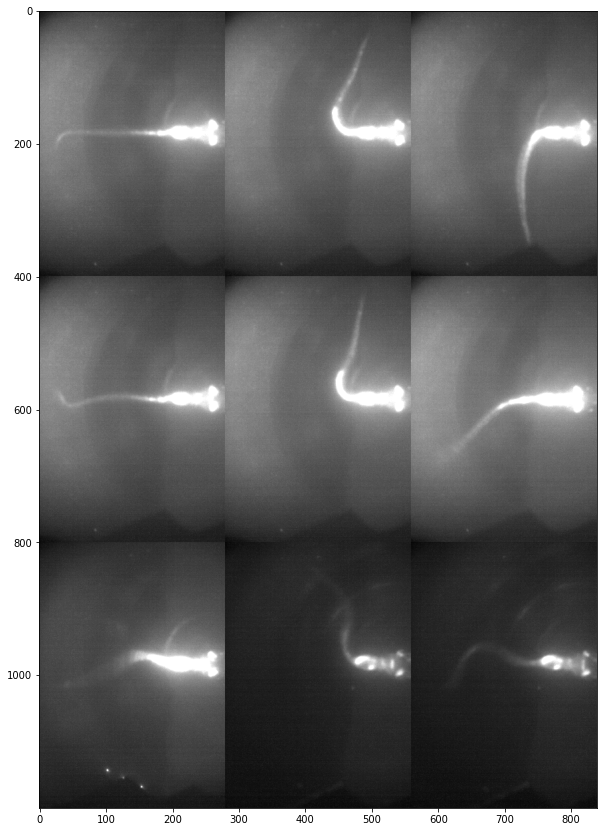

In [5]:
import matplotlib.pyplot as plt
from skimage.util import montage

images = images[image_indices[:], :, :]
images = np.transpose(images, (0, 2, 1))

plt.rcParams["figure.figsize"] = (10,20)
plt.imshow(montage(images), cmap='gray')
